## Import main libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn_features.transformers import DataFrameSelector

In [2]:
df = pd.read_csv("housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [5]:
df.drop_duplicates(inplace=True)
df.shape

(20640, 10)

## EDA

In [6]:
replicates = df["ocean_proximity"].value_counts()
replicates.values

array([9136, 6551, 2658, 2290,    5], dtype=int64)

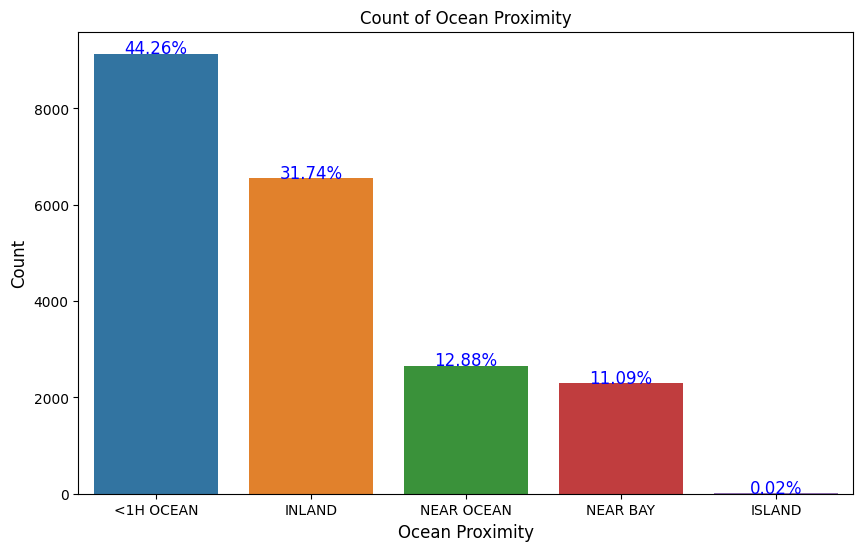

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x="ocean_proximity", data=df, order=replicates.index)
plt.title("Count of Ocean Proximity", c="k", fontsize=12)
plt.xlabel("Ocean Proximity",fontsize=12)
plt.ylabel("Count",fontsize=12)
for i in range(len(replicates)):
    count = replicates.values[i]
    text = f"{count*100/sum(replicates):.2f}%"
    plt.text(x=i, y=count, s=text, ha="center", c="b", fontsize=12)
plt.show()

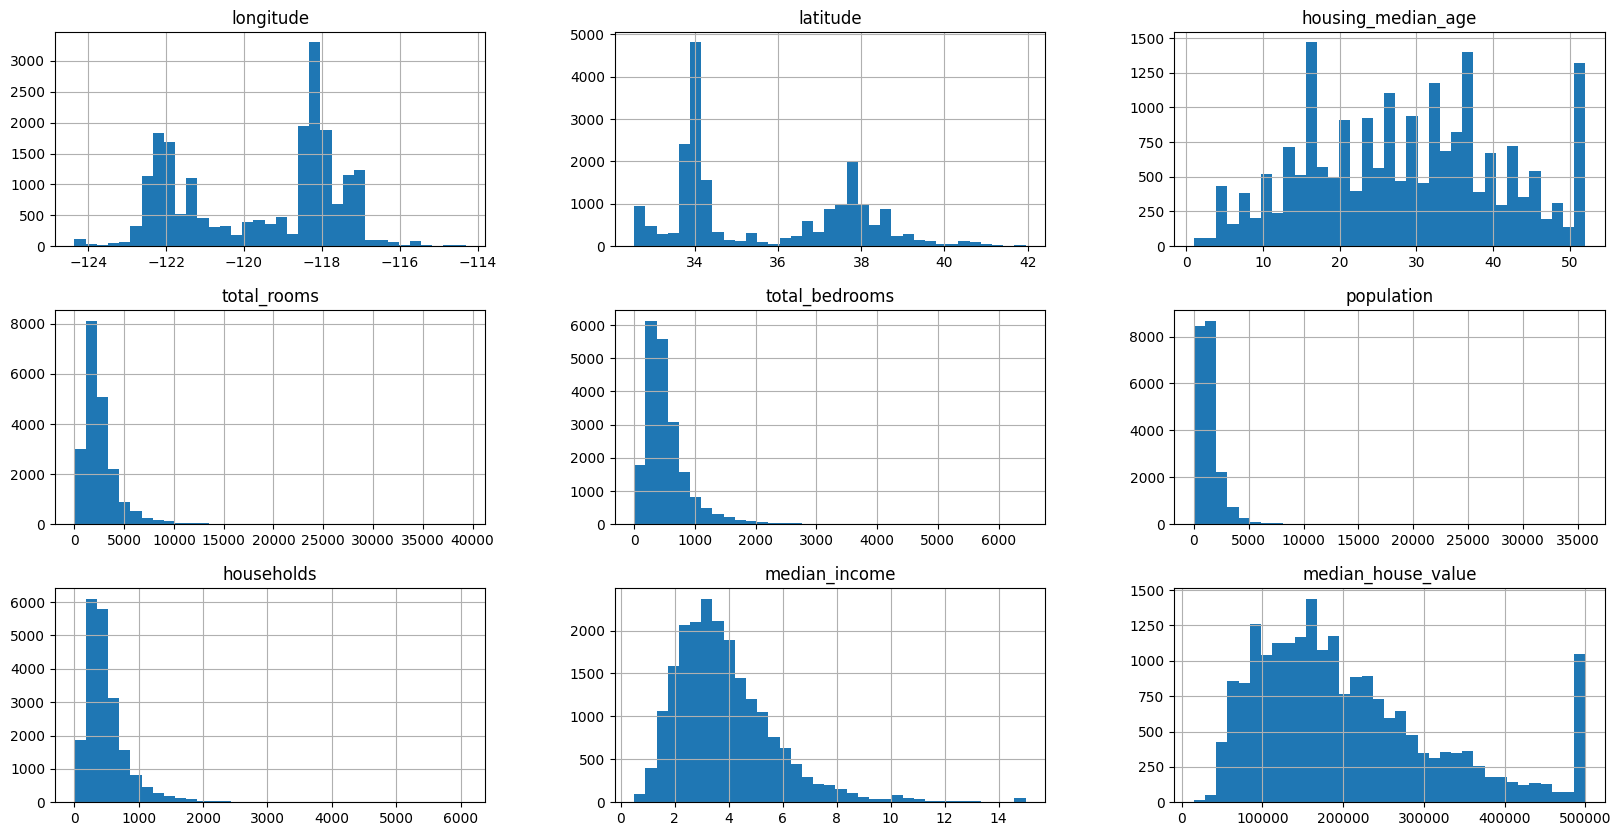

In [8]:
## Histogram of numerical data
df.hist(bins=35, figsize=(20, 10))
plt.show()

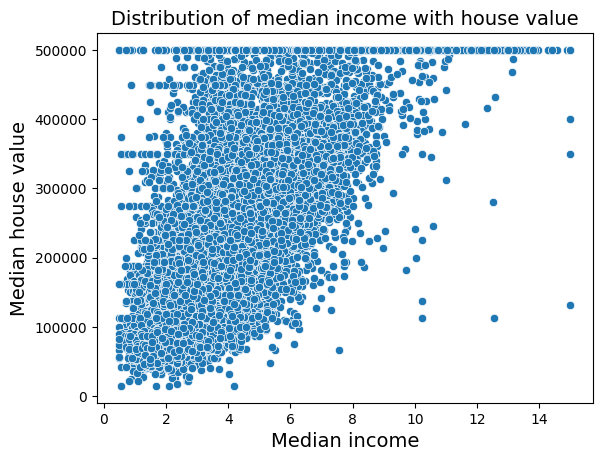

In [9]:
## Scatter plot an important feature (median income) with median house value
sns.scatterplot(x="median_income", y="median_house_value", data=df)
plt.title("Distribution of median income with house value", fontsize=14, c="k")
plt.xlabel("Median income", fontsize=14, c="k")
plt.ylabel("Median house value", fontsize=14, c="k")
plt.show()

In [10]:
df["median_house_value"].describe()

count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64

In [11]:
house_values_bins = pd.cut(x=df["median_house_value"], bins=[-np.inf, 100000, 200000, 300000, 400000, 500000, np.inf], labels=["0:100k", "100k:200k", "300k:400k", "400k:500k",
                                                                                                           "500k:600k", "600k<"])

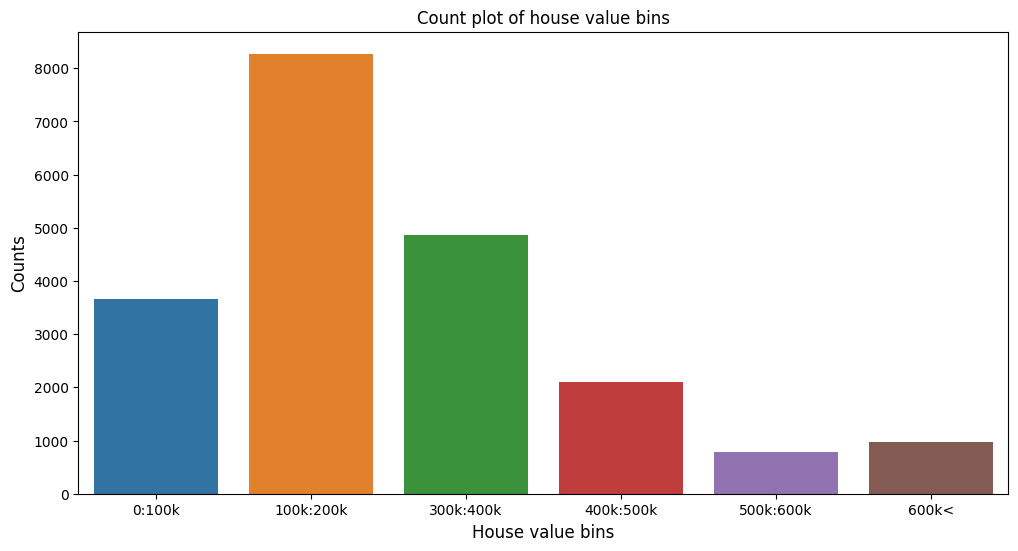

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(x=house_values_bins)
plt.title("Count plot of house value bins", fontsize=12, c="k")
plt.xlabel("House value bins", fontsize=12, c="k")
plt.ylabel("Counts", fontsize=12, c="k")
plt.show()

In [13]:
df["median_income"].describe()

count    20640.000000
mean         3.870671
std          1.899822
min          0.499900
25%          2.563400
50%          3.534800
75%          4.743250
max         15.000100
Name: median_income, dtype: float64

In [14]:
median_income_bins = pd.cut(x=df["median_income"], bins=[-np.inf, 1.5, 3, 4.5, 6, np.inf], labels=["0:1k", "1k:3k", "3k:4k", "4k:6k",
                                                                                                            "6k<"])

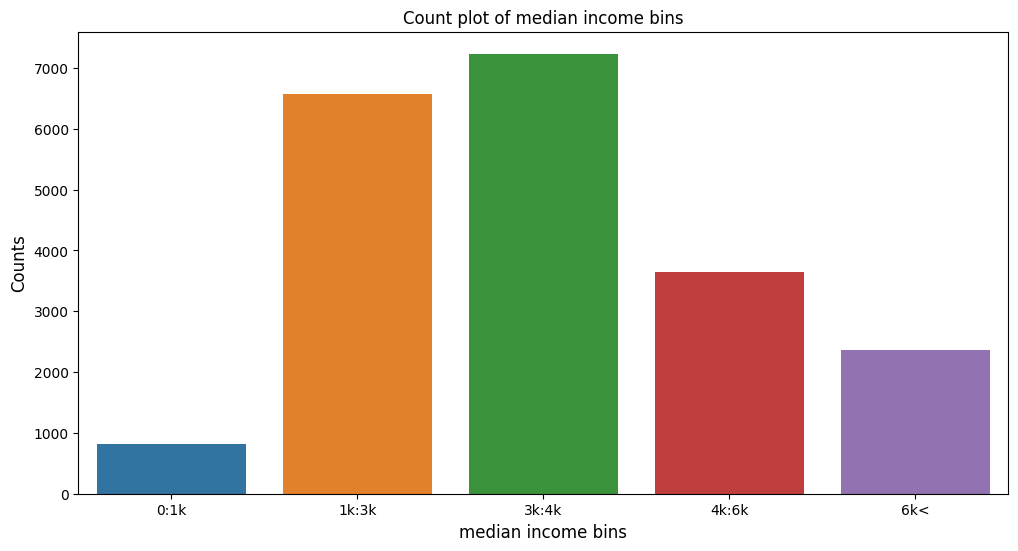

In [15]:
plt.figure(figsize=(12, 6))
sns.countplot(x=median_income_bins)
plt.title("Count plot of median income bins", fontsize=12, c="k")
plt.xlabel("median income bins", fontsize=12, c="k")
plt.ylabel("Counts", fontsize=12, c="k")
plt.show()

## Bivariate visualization

c:\Users\PC\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


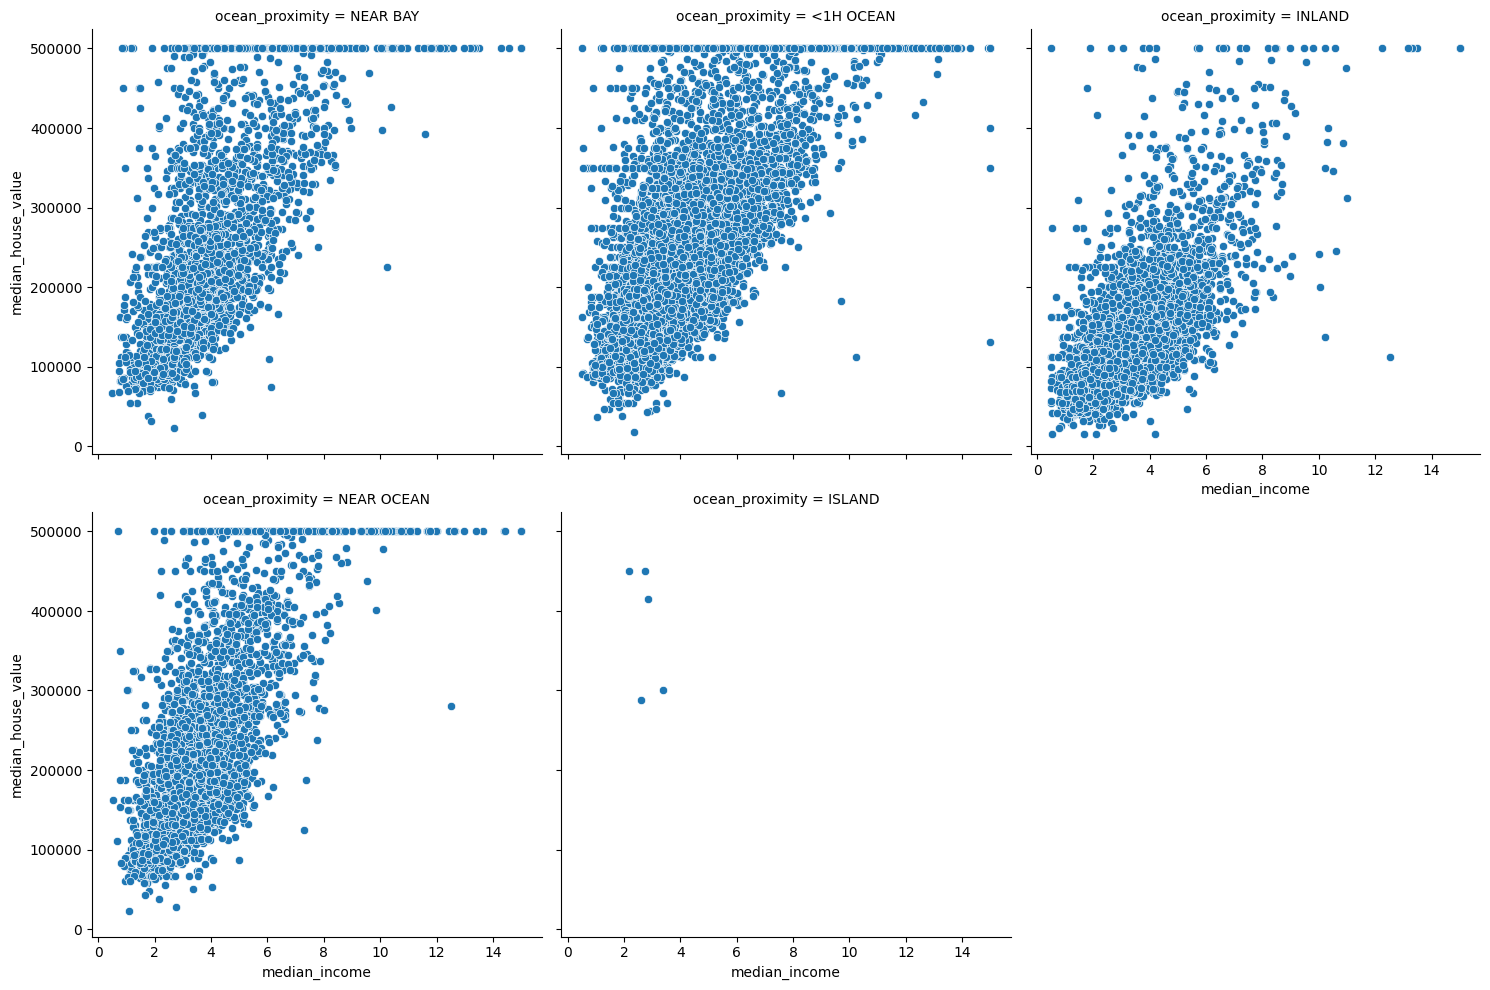

In [16]:
# Scatter plot between median income and median house value
sns.relplot(x="median_income", y="median_house_value", col="ocean_proximity", data=df, kind="scatter",col_wrap=3)
plt.show()

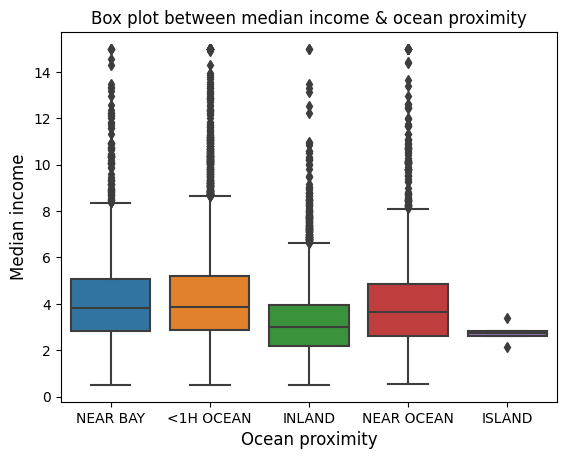

In [17]:
# Check box pltot
sns.boxplot(y="median_income", data=df, x="ocean_proximity")
plt.title("Box plot between median income & ocean proximity", fontsize=12, c="k")
plt.xlabel("Ocean proximity", fontsize=12, c="k")
plt.ylabel("Median income", fontsize=12, c="k")
plt.show()

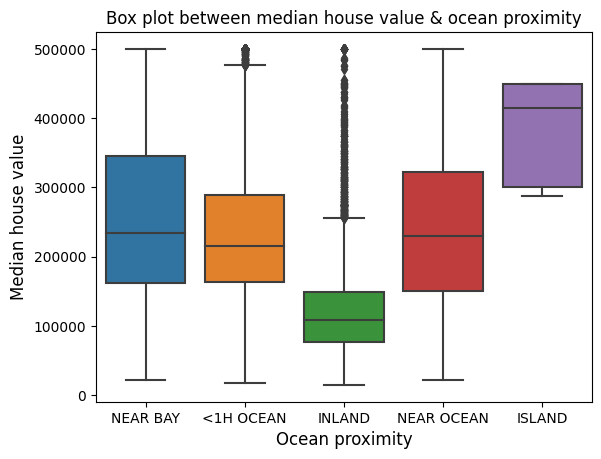

In [18]:
sns.boxplot(y="median_house_value", data=df, x="ocean_proximity")
plt.title("Box plot between median house value & ocean proximity", fontsize=12, c="k")
plt.xlabel("Ocean proximity", fontsize=12, c="k")
plt.ylabel("Median house value", fontsize=12, c="k")
plt.show()

#### Multivariate visualization

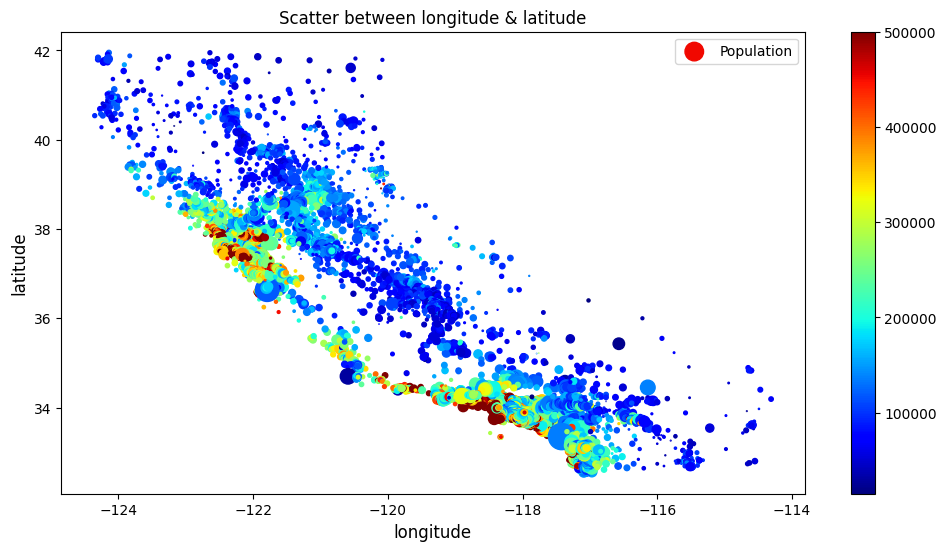

In [19]:
plt.figure(figsize=(12, 6))
sc = plt.scatter(df["longitude"], df["latitude"], s=df["population"]/100, c=df["median_house_value"], cmap=plt.get_cmap("jet"), label="Population")
plt.colorbar(sc)
plt.title("Scatter between longitude & latitude", fontsize=12, c="k")
plt.xlabel("longitude", fontsize=12, c="k")
plt.ylabel("latitude", fontsize=12, c="k")
plt.legend()
plt.show()


## Check the correlation between features and target

In [20]:
df.drop("ocean_proximity", axis=1).corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

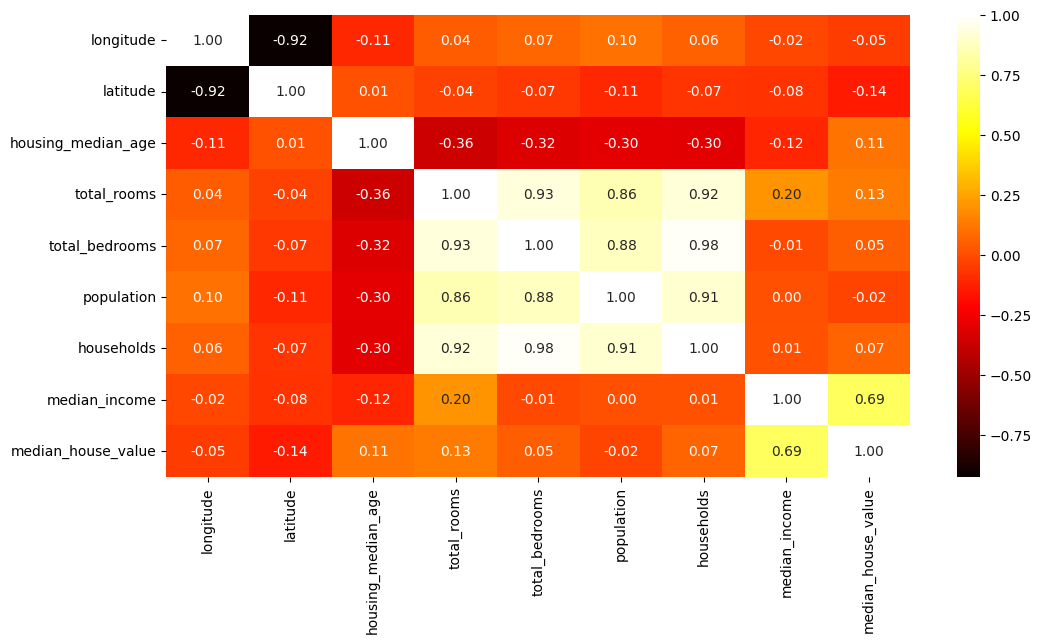

In [21]:
## Heat map of correlation
plt.figure(figsize=(12, 6))
sns.heatmap(df.drop("ocean_proximity", axis=1).corr(), annot=True, cmap="hot", fmt=".2f")
plt.show()

## Feature Engineering

In [22]:
df["rooms_in_house"] = df["total_rooms"] / df["households"]
df["bed_rooms_in_house"] = df["total_bedrooms"] / df["total_rooms"]

In [23]:
df.drop("ocean_proximity", axis=1).corr()["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
rooms_in_house        0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bed_rooms_in_house   -0.255880
Name: median_house_value, dtype: float64

In [24]:
# Split the data
X = df.drop("median_house_value", axis= 1)
y = df["median_house_value"]

In [25]:
y = np.array(y)

In [26]:
scaler_y = StandardScaler()

y = scaler_y.fit_transform(y.reshape(-1, 1)) 
y=y.ravel()

In [27]:
X_train,X_test,y_train,y_test = train_test_split(X, y , shuffle=True, random_state=42, test_size=0.2)

In [28]:
num_cols = [col for col in X_train.columns if X_train[col].dtype in ["float32", "float64", "int32", "int64"]]
categ_cols = [col for col in X_train.columns if X_train[col].dtype not in ["float32", "float64", "int32", "int64"]]

## Dealing with nulls and scaling the data

In [29]:
num_pipeline = Pipeline(steps=[
('selector', DataFrameSelector(num_cols)),
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())
])

categ_pipeline = Pipeline(steps=[
('selector', DataFrameSelector(categ_cols)),
('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
('ohe', OneHotEncoder(sparse_output=False))
])

total_pipeline = FeatureUnion(transformer_list=[
('num', num_pipeline),
('categ', categ_pipeline)])

X_train_final = total_pipeline.fit_transform(X_train)
X_test_final = total_pipeline.transform(X_test)


## Train the model

## First using Linear Regression

In [30]:
model = LinearRegression()
model.fit(X_train_final, y_train)
pred = model.predict(X_train_final)
print(f"RMSE = {np.sqrt(mean_squared_error(y_train, pred))}")

RMSE = 0.585799871806743


In [31]:
scores = cross_val_score(model, X_train_final, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = [-score for score in scores]
rmse_scores = [np.sqrt(score) for score in mse_scores]
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {np.mean(rmse_scores)}")

RMSE scores: [0.5896288366891849, 0.57719673812065, 0.5779640538550554, 0.5794657371278541, 0.6136736337652647]
Mean RMSE: 0.5875857999116019


## Random Forest

In [32]:
random_forest = RandomForestRegressor()
params = {"n_estimators" : np.arange(100, 300, 50), "max_depth" : np.arange(2, 10, 2)} 
grid_model = GridSearchCV(estimator= random_forest, param_grid=params, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
grid_model.fit(X_train_final, y_train)
print(f"Grid model best paraemeters {grid_model.best_params_}")
best_model = grid_model.best_estimator_
best_model.fit(X_train_final, y_train)

Grid model best paraemeters {'max_depth': 8, 'n_estimators': 150}


RandomForestRegressor(max_depth=8, n_estimators=150)

In [33]:
pred = best_model.predict(X_train_final)
print(f"RMSE = {np.sqrt(mean_squared_error(y_train, pred))}")

RMSE = 0.4564612192119899


In [35]:
scores = cross_val_score(best_model, X_train_final, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = [-score for score in scores]
rmse_scores = [np.sqrt(score) for score in mse_scores]
print(f"RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {np.mean(rmse_scores)}")

RMSE scores: [0.5063284136147358, 0.5021684593726092, 0.5068498808884726, 0.49237754829164737, 0.5085523073831575]
Mean RMSE: 0.5032553219101246


In [37]:
last_pred = best_model.predict(X_test_final)
mse = mean_squared_error(y_test, last_pred)
print(f"RMSE {mse}")

RMSE 0.25862200634113547


In [42]:
last_pred_true_prices = scaler_y.inverse_transform(last_pred.reshape(-1, 1))
print("Predicted true prices:", last_pred_true_prices)

Predicted true prices: [[ 64983.12353719]
 [ 80177.2494232 ]
 [405607.75137016]
 ...
 [494938.10006148]
 [ 80107.19898663]
 [223975.19028722]]
